# Importing Required Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Functions

In [173]:
def convert_cat(df, cat_cols, output_var = 'Output'):
    """
    This function converts all categorical columns into numerical boolean columns.
    
    There are 3 parameters: df, cat_cols, and output_var. 
    
    1. df is the dataframe which needs to have categorical variables converted to numerical variables
    2. cat_cols needs to be a list that contains the names of all categorical columns that need to be converted.
    3. output_var is the name of the output or response variable.  It is set to 'Output' as default."""
    
    df.reset_index(inplace = True, drop = True)
    df_out = df.copy()
    
    for col in cat_cols:
        dummy_col = pd.get_dummies(df_out[col],drop_first = True)
        df_out.drop(col,axis=1, inplace = True)
        df_out_minus_y = df_out.drop(output_var,axis= 1).join(dummy_col)
        df_out = df_out_minus_y.join(pd.DataFrame(df_out.loc[:,output_var]))
    
    return df_out

In [157]:
def normalize(df):
    """
    This function takes in a dataframe as a parameter and returns the same dataframe with all the features normalized between 0 and 1 using rescaling (min-max normalization)
    """
    l_min = []
    for i in df.drop(df.columns[-1],axis = 1).columns:
        l_min.append(df.describe()[i][3])
    l_max = []
    for i in df.drop(df.columns[-1],axis = 1).columns:
        l_max.append(df.describe()[i][-1])
    
    t_min = list(zip(df.drop(df.columns[-1],axis = 1).columns, l_min))
    t_max = list(zip(df.drop(df.columns[-1],axis = 1).columns, l_max))
    
    d_min = {}
    for col,val in t_min:
        d_min[col]=val
    
    d_max = {}
    for col,val in t_max:
        d_max[col]=val
    
    df_copy = df.copy()
    for key in d_min.keys():
        df_copy[key] = df_copy[key].apply(lambda x: (x - d_min[key])/ (d_max[key] - d_min[key]))
    
    return df_copy

In [172]:
def stoch_grad_desc(dataset,alpha = 0.3,epoch = 10,algo = 'lin'):
    """
    This function returns a list of the coefficients for the specified algorithm.  
    Currently, this function only performs Linear and Logistic Regression.
    
    The 4 parameters are: dataset, alpha, epoch, and algo
    
    1. dataset needs to be a pandas DataFrame
    2. alpha is the alpha value used in stochiastic gradient descent.  It is set at 0.3 by default.
    3. epoch is the number of iterations through each row in the dataset algorithm will perform.  epoch is set to 10 by default.
    4. algo is the specific algorithm to be used.  algo is 'lin' by default for Linear Regression but can also be specified as 'log' for Logistic Regression
    """
    dataset.reset_index(inplace = True, drop = True)
    count_rows = dataset.count()[1]
    from math import exp
    dataset_1 = pd.DataFrame(pd.Series(np.ones(dataset.count()[0])),columns = ['Xo']).join(dataset)
    
    coeffs = list(np.zeros(len(dataset_1.columns[0:-1])))
    coeffs = [i + 1 for i in coeffs]
    
    for i in range(epoch):
        for row in range(count_rows):
            y = dataset_1.iloc[row,-1]
            output_terms = []
            
            for col in dataset_1.columns[:-1]:
                output_terms.append((coeffs[dataset_1.columns.get_loc(col)],dataset_1.loc[row,col]))
            output_list = [(x*y) for (x,y) in output_terms]
            output = sum(output_list)
            
            if algo == 'lin':
                pred = output
                for i in range(len(coeffs)):
                    coeffs[int(i)] += alpha * (dataset_1.iloc[row,-1] - pred) * dataset_1.iloc[row,int(i)]
                
            elif algo == 'log':
                pred = 1 / (1 + exp(-output))
                for i in range(len(coeffs)):
                    coeffs[i] = coeffs[i] + alpha * (y - pred) * pred * (1 - pred) * dataset_1.iloc[row,i]
                    
    return coeffs
        

In [171]:
def make_predictions(dataset, coeff_list,algo = 'lin'):
    """
    This function takes in a pandas DataFrame and a list that contains 
    coefficients for the specified algorith used in the stoch_grad_desc function
    and returns the same dataset (with the addition of the first column being 1s to
    represent X0 in the regression formula) plus a new column at the end, 'Prediction'.
    
    There are 3 parameters: dataset, coeff_list, and algo
    
    1. dataset is the dataframe to used to make predictions dataset needs to be a Pandas DataFrame
    2. coeff_list should be the list that was the result of running the stoch_grad_desc function
    3. algo is the specific algorithm to be used.  algo is set to 'lin' by default but can be set to 'log'"""
    
    from math import exp
    
    dataset.reset_index(inplace = True, drop = True)
    
    dataset_out = pd.DataFrame(pd.Series(np.ones(dataset.count()[0]))).join(dataset)
    dataset_out.rename(mapper = {0:'X0'},axis = 1, inplace = True)
    
    coeffs = coeff_list
    pred = []
    
    for row in range(dataset_out.count()[0]):
        output_terms = []
        for col in dataset_out.columns[0:-1]:
            output_terms.append((coeffs[dataset_out.columns.get_loc(col)],dataset_out.loc[row,col]))
        output_list = [x*y for (x,y) in output_terms]
        
        output = sum(output_list)
        if algo == 'lin':
            pred.append(output)
        
        elif algo == 'log':
            pred.append(1/(1 + exp(-output)))
    dataset_out = dataset_out.join(pd.DataFrame(pred))
    dataset_out.rename(mapper = {0: 'Prediction'},axis = 1, inplace = True)
    
    if algo == 'log':
        dataset_out['Crisp'] = dataset_out['Prediction'].apply(lambda predi: 1 if predi >= 0.5 else 0)
        dataset_out['Correct?'] = dataset_out.iloc[:,-3] == dataset_out['Crisp']
    
    return dataset_out

In [169]:
def check_accuracy(df, algo = 'lin'):
    """
    This function takes in a pandas DataFrame and returns the accuracy of the model
    
    There are 2 parameters: df and algo
    
    1. df needs to be a Pandas DataFrame and algo is the algorithm used.
    2. algo is set to 'lin' by default but can also be specified as 'log'"""
    
    if algo == 'lin':
        df_out = df.copy()
        df_out['error'] = df.iloc[:,-2] - df.iloc[:,-1]
        RMSE = (sum(df_out['error']**2)/df_out.count()[0]+1) ** 0.5
        acc = (np.mean(df_out.iloc[:,-3]) - RMSE) / np.mean(df_out.iloc[:,-3])
        return {'acc':acc,'RMSE':RMSE}
    
    elif algo == 'log':
        return sum(df['Correct?']/df.count()[0])

In [168]:
def split_df(df,test_size = 0.3,df_to_return = 'df_train'):
    """
    This function takes in a Pandas DataFrame and returns a 
    dataframe that is a subset of that Pandas DataFrame.
    
    There are 3 parameters: df, test_size, and df_to_return
    
    df needs to be a Pandas DataFrame and is the superset dataframe to be divided.
    test_size is the proportion of the dataframe you want to be the testing dataset.
    test_size is set to 0.3 by default.
    df_to_return needs to specified as either 'df_train' or df_test' 
    to return the correct subset dataframe. df_to_return is set to 'df_train' by default
    """
    split_num = int(df.count()[0] * (1-test_size) //1)
    df_train = df.iloc[:split_num,:]
    df_test = df.iloc[split_num:,:]
    if df_to_return == 'df_train':
        return df_train
    elif df_to_return == 'df_test':
        return df_test

# Logistic Regression (Titanic Dataset)

In [11]:
titanic_test = pd.read_csv(r'C:\Users\ssiva\Downloads\Python-Data-Science-and-Machine-Learning-Bootcamp\Python-Data-Science-and-Machine-Learning-Bootcamp\Machine Learning Sections\Logistic-Regression\titanic_test.csv')

In [13]:
titanic_train = pd.read_csv(r'C:\Users\ssiva\Downloads\Python-Data-Science-and-Machine-Learning-Bootcamp\Python-Data-Science-and-Machine-Learning-Bootcamp\Machine Learning Sections\Logistic-Regression\titanic_train.csv')

In [14]:
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [25]:
titanic_train.drop(['PassengerId','Name','Ticket'],axis = 1,inplace = True)

In [26]:
titanic_test.drop(['PassengerId','Name','Ticket'],axis = 1,inplace = True)

In [27]:
titanic_train.isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [16]:
titanic_train.drop(['Cabin'],axis = 1,inplace = True)
titanic_test.drop(['Cabin'],axis = 1,inplace = True)

In [17]:
titanic_train.dropna(inplace = True)
titanic_test.dropna(inplace = True)

In [28]:
titanic_train.count()[0]

712

In [29]:
titanic_train.head(6)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
5,0,1,male,54.0,0,0,51.8625,S


In [31]:
tit_train_cnvrtd = convert_cat(titanic_train,['Sex','Embarked'],output_var = 'Survived')
tit_train_cnvrtd.head()

,Pclass,Age,SibSp,Parch,Fare,male,Q,S,Survived
0,3,22.0,1,0,7.2500,1,0,1,0
1,1,38.0,1,0,71.2833,0,0,0,1
2,3,26.0,0,0,7.9250,0,0,1,1
3,1,35.0,1,0,53.1000,0,0,1,1
4,3,35.0,0,0,8.0500,1,0,1,0


In [34]:
# tit_test_cnvrtd = convert_cat(titanic_test,['Sex','Embarked'],output_var = 'Survived')
# tit_test_cnvrtd.head()
titanic_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


In [36]:
split_num = int(tit_train_cnvrtd.count()[0] * 0.7 //1)
split_num

498

In [38]:
tit_train = tit_train_cnvrtd.iloc[:split_num,:]
tit_train.head()

,Pclass,Age,SibSp,Parch,Fare,male,Q,S,Survived
0,3,22.0,1,0,7.2500,1,0,1,0
1,1,38.0,1,0,71.2833,0,0,0,1
2,3,26.0,0,0,7.9250,0,0,1,1
3,1,35.0,1,0,53.1000,0,0,1,1
4,3,35.0,0,0,8.0500,1,0,1,0


In [39]:
tit_test = tit_train_cnvrtd.iloc[split_num:,:]
tit_test.head()

,Pclass,Age,SibSp,Parch,Fare,male,Q,S,Survived
498,3,51.0,0,0,7.0542,1,0,1,0
499,1,32.0,0,0,30.5000,1,0,0,1
500,3,9.0,3,2,27.9000,0,0,1,0
501,2,28.0,0,0,13.0000,0,0,1,1
502,3,32.0,0,0,7.9250,1,0,1,0


In [45]:
tit_train_norm = normalize(tit_train)
tit_test_norm = normalize(tit_test)

In [46]:
tit_train_norm.head()

,Pclass,Age,SibSp,Parch,Fare,male,Q,S,Survived
0,1.0,0.268139,0.2,0.0,0.014151,1.0,0.0,1.0,0
1,0.0,0.470032,0.2,0.0,0.139136,0.0,0.0,0.0,1
2,1.0,0.318612,0.0,0.0,0.015469,0.0,0.0,1.0,1
3,0.0,0.432177,0.2,0.0,0.103644,0.0,0.0,1.0,1
4,1.0,0.432177,0.0,0.0,0.015713,1.0,0.0,1.0,0


In [55]:
coeffs_list = stoch_grad_desc(tit_train_norm,alpha = 0.5, epoch = 100,algo='log')

In [56]:
coeffs_list

[5.297875928276206,
 -3.787762457158588,
 -3.9152703370653277,
 -1.4904885285807647,
 0.6840651195676772,
 -2.5720391672249105,
 -2.901730290347972,
 0.6929381373404175,
 0.0914470367436114]

In [61]:
tit_train_pred = make_predictions(tit_train_norm,coeff_list = coeffs_list,algo = 'log')

In [62]:
tit_test_pred = make_predictions(tit_test_norm,coeff_list = coeffs_list,algo = 'log')

In [65]:
check_accuracy(tit_train_pred)

0.7931726907630586

In [66]:
check_accuracy(tit_test_pred)

0.813084112149529

# Linear Regression (Housing Dataset)

In [70]:
cust = pd.read_csv(r'C:\Users\ssiva\Downloads\Python-Data-Science-and-Machine-Learning-Bootcamp\Python-Data-Science-and-Machine-Learning-Bootcamp\Machine Learning Sections\Linear-Regression\Ecommerce Customers')

In [71]:
cust.head()

,Email,Address,Avatar,Avg. Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent
0,mstephenson@fernandez.com,"835 Frank Tunnel\nWrightmouth, MI 82180-9605",Violet,34.497268,12.655651,39.577668,4.082621,587.951054
1,hduke@hotmail.com,"4547 Archer Common\nDiazchester, CA 06566-8576",DarkGreen,31.926272,11.109461,37.268959,2.664034,392.204933
2,pallen@yahoo.com,"24645 Valerie Unions Suite 582\nCobbborough, D...",Bisque,33.000915,11.330278,37.110597,4.104543,487.547505
3,riverarebecca@gmail.com,"1414 David Throughway\nPort Jason, OH 22070-1220",SaddleBrown,34.305557,13.717514,36.721283,3.120179,581.852344
4,mstephens@davidson-herman.com,"14023 Rodriguez Passage\nPort Jacobville, PR 3...",MediumAquaMarine,33.330673,12.795189,37.536653,4.446308,599.406092


In [72]:
cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
Email                   500 non-null object
Address                 500 non-null object
Avatar                  500 non-null object
Avg. Session Length     500 non-null float64
Time on App             500 non-null float64
Time on Website         500 non-null float64
Length of Membership    500 non-null float64
Yearly Amount Spent     500 non-null float64
dtypes: float64(5), object(3)
memory usage: 31.3+ KB


In [73]:
cust.describe()

,Avg. Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,33.053194,12.052488,37.060445,3.533462,499.314038
std,0.992563,0.994216,1.010489,0.999278,79.314782
min,29.532429,8.508152,33.913847,0.269901,256.670582
25%,32.341822,11.388153,36.349257,2.930450,445.038277
50%,33.082008,11.983231,37.069367,3.533975,498.887875
75%,33.711985,12.753850,37.716432,4.126502,549.313828
max,36.139662,15.126994,40.005182,6.922689,765.518462


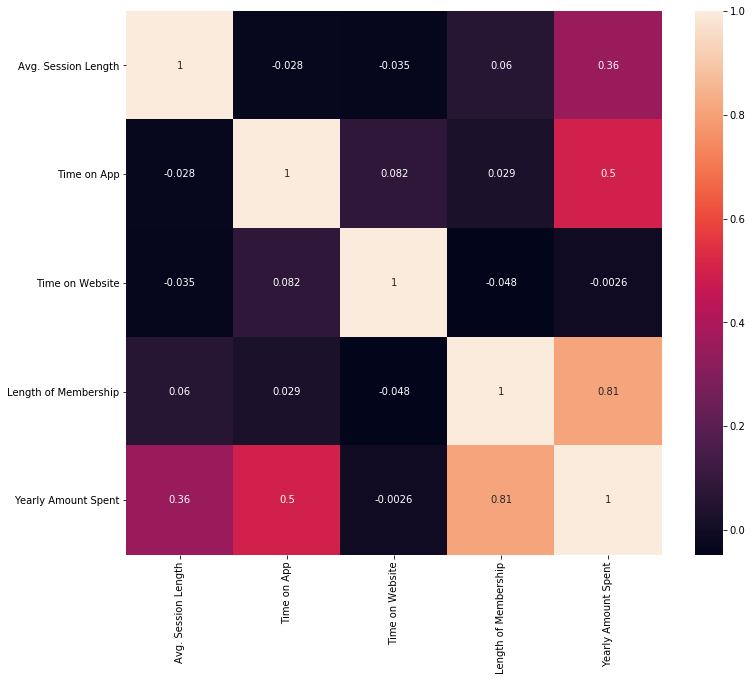

In [78]:
plt.rcParams['figure.figsize'] = (12,10)
sns.heatmap(cust.corr(),annot=True)

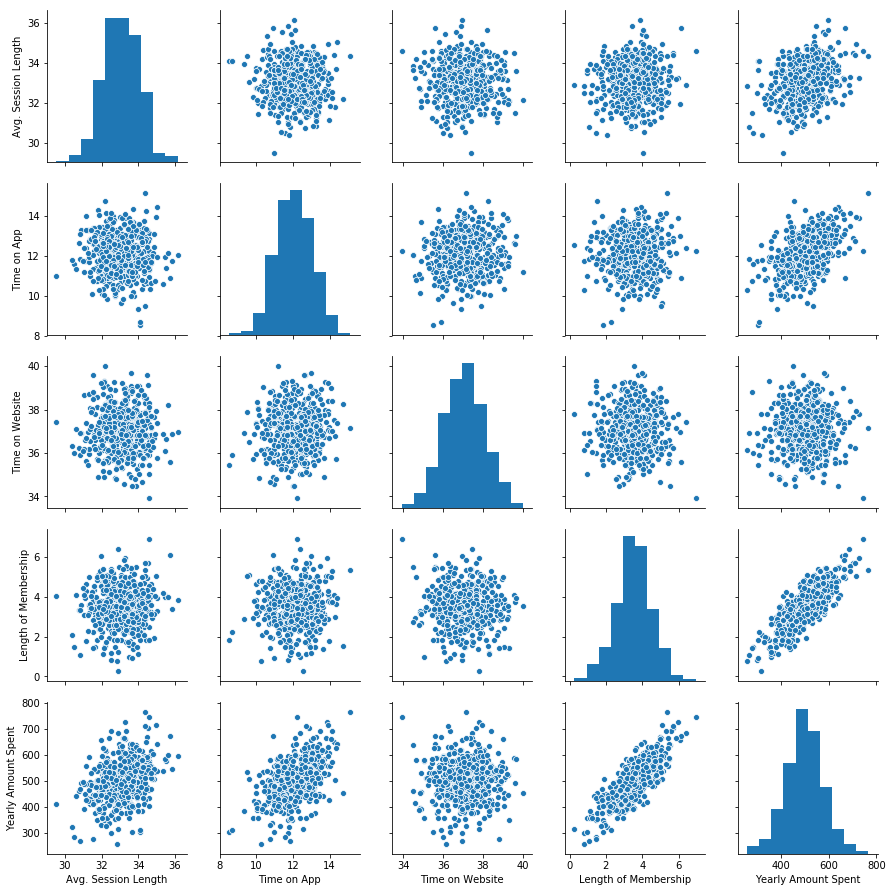

In [79]:
sns.pairplot(data = cust)

In [80]:
cust.isna().sum()

Email                   0
Address                 0
Avatar                  0
Avg. Session Length     0
Time on App             0
Time on Website         0
Length of Membership    0
Yearly Amount Spent     0
dtype: int64

In [81]:
cust.head(3)

,Email,Address,Avatar,Avg. Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent
0,mstephenson@fernandez.com,"835 Frank Tunnel\nWrightmouth, MI 82180-9605",Violet,34.497268,12.655651,39.577668,4.082621,587.951054
1,hduke@hotmail.com,"4547 Archer Common\nDiazchester, CA 06566-8576",DarkGreen,31.926272,11.109461,37.268959,2.664034,392.204933
2,pallen@yahoo.com,"24645 Valerie Unions Suite 582\nCobbborough, D...",Bisque,33.000915,11.330278,37.110597,4.104543,487.547505


In [82]:
cust['Email_site'] = cust['Email'].apply(lambda eml: eml.split('@')[-1])

In [83]:
cust.head()

,Email,Address,Avatar,Avg. Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent,Email_site
0,mstephenson@fernandez.com,"835 Frank Tunnel\nWrightmouth, MI 82180-9605",Violet,34.497268,12.655651,39.577668,4.082621,587.951054,fernandez.com
1,hduke@hotmail.com,"4547 Archer Common\nDiazchester, CA 06566-8576",DarkGreen,31.926272,11.109461,37.268959,2.664034,392.204933,hotmail.com
2,pallen@yahoo.com,"24645 Valerie Unions Suite 582\nCobbborough, D...",Bisque,33.000915,11.330278,37.110597,4.104543,487.547505,yahoo.com
3,riverarebecca@gmail.com,"1414 David Throughway\nPort Jason, OH 22070-1220",SaddleBrown,34.305557,13.717514,36.721283,3.120179,581.852344,gmail.com
4,mstephens@davidson-herman.com,"14023 Rodriguez Passage\nPort Jacobville, PR 3...",MediumAquaMarine,33.330673,12.795189,37.536653,4.446308,599.406092,davidson-herman.com


In [85]:
cust['Email_site'].value_counts()

gmail.com                 87
hotmail.com               87
yahoo.com                 76
williams.com               2
jones.com                  2
moore.com                  2
davis.com                  2
edwards.com                2
johnson.com                2
jackson.com                2
barber.com                 2
lee.com                    2
peterson.com               1
martinez.info              1
torres-miles.net           1
bailey-gordon.net          1
salas.com                  1
hale-duncan.net            1
cox.org                    1
garcia.com                 1
white.com                  1
walker.com                 1
fernandez.com              1
johnson-herring.net        1
fischer.com                1
hunter.com                 1
mcdonald-smith.biz         1
walsh-obrien.net           1
gibbs.net                  1
wheeler.net                1
                          ..
kaiser.com                 1
cook.info                  1
lee-wilson.com             1
ball-arroyo.co

In [88]:
'djflfj' not in ['gmail.com','yahoo.com']

True

In [89]:
cust['Email_site'] = cust['Email_site'].apply(lambda site: 'Other' if site not in ['gmail.com','yahoo.com','hotmail.com'] else site)

In [90]:
cust['Email_site'].value_counts()

Other          250
gmail.com       87
hotmail.com     87
yahoo.com       76
Name: Email_site, dtype: int64

In [91]:
cust.head()

,Email,Address,Avatar,Avg. Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent,Email_site
0,mstephenson@fernandez.com,"835 Frank Tunnel\nWrightmouth, MI 82180-9605",Violet,34.497268,12.655651,39.577668,4.082621,587.951054,Other
1,hduke@hotmail.com,"4547 Archer Common\nDiazchester, CA 06566-8576",DarkGreen,31.926272,11.109461,37.268959,2.664034,392.204933,hotmail.com
2,pallen@yahoo.com,"24645 Valerie Unions Suite 582\nCobbborough, D...",Bisque,33.000915,11.330278,37.110597,4.104543,487.547505,yahoo.com
3,riverarebecca@gmail.com,"1414 David Throughway\nPort Jason, OH 22070-1220",SaddleBrown,34.305557,13.717514,36.721283,3.120179,581.852344,gmail.com
4,mstephens@davidson-herman.com,"14023 Rodriguez Passage\nPort Jacobville, PR 3...",MediumAquaMarine,33.330673,12.795189,37.536653,4.446308,599.406092,Other


In [95]:
cust.drop(['Email','Address','Avatar'],axis = 1,inplace = True)

In [96]:
cust.head(2)

,Avg. Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent,Email_site
0,34.497268,12.655651,39.577668,4.082621,587.951054,Other
1,31.926272,11.109461,37.268959,2.664034,392.204933,hotmail.com


In [97]:
customer = cust.copy()

In [98]:
customer = convert_cat(customer, cat_cols = ['Email_site'],output_var='Yearly Amount Spent')

In [99]:
customer.head()

,Avg. Session Length,Time on App,Time on Website,Length of Membership,gmail.com,hotmail.com,yahoo.com,Yearly Amount Spent
0,34.497268,12.655651,39.577668,4.082621,0,0,0,587.951054
1,31.926272,11.109461,37.268959,2.664034,0,1,0,392.204933
2,33.000915,11.330278,37.110597,4.104543,0,0,1,487.547505
3,34.305557,13.717514,36.721283,3.120179,1,0,0,581.852344
4,33.330673,12.795189,37.536653,4.446308,0,0,0,599.406092


In [101]:
customer = normalize(customer)
customer.head(3)

,Avg. Session Length,Time on App,Time on Website,Length of Membership,gmail.com,hotmail.com,yahoo.com,Yearly Amount Spent
0,0.751425,0.626620,0.929816,0.573101,0.0,0.0,0.0,587.951054
1,0.362306,0.393016,0.550801,0.359869,0.0,1.0,0.0,392.204933
2,0.524953,0.426378,0.524803,0.576396,0.0,0.0,1.0,487.547505


In [113]:
cust_split_num = int(customer.count()[0]*.7 // 1)
cust_split_num

350

In [118]:
cust_train = split_df(customer)
cust_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 8 columns):
Avg. Session Length     350 non-null float64
Time on App             350 non-null float64
Time on Website         350 non-null float64
Length of Membership    350 non-null float64
gmail.com               350 non-null float64
hotmail.com             350 non-null float64
yahoo.com               350 non-null float64
Yearly Amount Spent     350 non-null float64
dtypes: float64(8)
memory usage: 22.0 KB


In [119]:
cust_test = split_df(customer,df_to_return='df_test')
cust_test.head()

,Avg. Session Length,Time on App,Time on Website,Length of Membership,gmail.com,hotmail.com,yahoo.com,Yearly Amount Spent
350,0.570875,0.632212,0.561411,0.534734,0.0,0.0,0.0,535.480775
351,0.402198,0.434913,0.703234,0.682183,0.0,1.0,0.0,533.396554
352,0.817767,0.335446,0.487142,0.567974,1.0,0.0,0.0,532.127449
353,0.608306,0.518028,0.326104,0.642352,0.0,0.0,1.0,558.948112
354,0.432033,0.636039,0.199460,0.482679,0.0,1.0,0.0,508.771907


In [150]:
customer_coeffs = stoch_grad_desc(dataset = cust_train,alpha = 0.01,epoch = 100,algo = 'lin')

In [151]:
customer_coeffs

[76.61413314870666,
 168.39849653189734,
 251.0124785419619,
 0.7298097407629542,
 405.2298018946992,
 -1.2321843341336065,
 -0.20476465273969294,
 -1.2627421533787266]

In [152]:
customer_predict_train = make_predictions(dataset = cust_train,coeff_list = customer_coeffs)
customer_predict_train.head()

,X0,Avg. Session Length,Time on App,Time on Website,Length of Membership,gmail.com,hotmail.com,yahoo.com,Yearly Amount Spent,Prediction
0,1.0,0.751425,0.626620,0.929816,0.573101,0.0,0.0,0.0,587.951054,593.358565
1,1.0,0.362306,0.393016,0.550801,0.359869,0.0,1.0,0.0,392.204933,382.304731
2,1.0,0.524953,0.426378,0.524803,0.576396,0.0,0.0,1.0,487.547505,504.734687
3,1.0,0.722409,0.787050,0.460890,0.428434,1.0,0.0,0.0,581.852344,568.544452
4,1.0,0.574861,0.647702,0.594748,0.627768,0.0,0.0,0.0,599.406092,590.825514


In [153]:
check_accuracy(customer_predict_train,algo = 'lin')

{'RMSE': 9.734625507527175, 'acc': 0.9805641778146358}

In [154]:
customer_predict_test = make_predictions(dataset = cust_test,coeff_list = customer_coeffs)
customer_predict_test.head()

,X0,Avg. Session Length,Time on App,Time on Website,Length of Membership,gmail.com,hotmail.com,yahoo.com,Yearly Amount Spent,Prediction
0,1.0,0.570875,0.632212,0.561411,0.534734,0.0,0.0,0.0,535.480775,548.541770
1,1.0,0.402198,0.434913,0.703234,0.682183,0.0,1.0,0.0,533.396554,530.261722
2,1.0,0.817767,0.335446,0.487142,0.567974,1.0,0.0,0.0,532.127449,527.809270
3,1.0,0.608306,0.518028,0.326104,0.642352,0.0,0.0,1.0,558.948112,568.358785
4,1.0,0.432033,0.636039,0.199460,0.482679,0.0,1.0,0.0,508.771907,504.558241


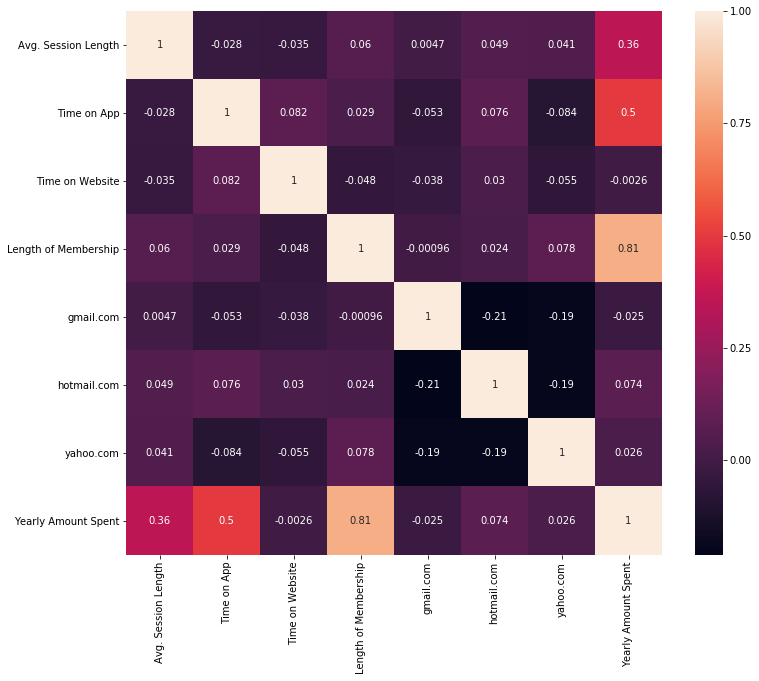

In [141]:
sns.heatmap(customer.corr(),annot=True)

In [155]:
check_accuracy(df = customer_predict_test,algo = 'lin')

{'RMSE': 10.68687112770578, 'acc': 0.9784411465857165}